In [77]:
import numpy as np
import pandas as pd
import cufflinks as cf
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.express as px
from datetime import datetime,date

%matplotlib inline
init_notebook_mode(connected=True)
cf.set_config_file(sharing='private',theme='pearl',offline=True)
#print("Cufflinks Version : {}".format(cf.__version__))

df = pd.read_csv('./data/btc-usd-max.csv',index_col=0,parse_dates=True )
df = df.resample('D').first()
df.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])
df2 = pd.read_csv('./data/eth-usd-max.csv',index_col=0,parse_dates=True )
df2.drop(["market_cap", "total_volume"], axis=1, inplace=True)
df2 = df2.resample('D').first()
df2['price'].fillna(method='ffill', inplace=True)
# to get the log price
# df['price'] = np.log(df['price'])

In [78]:
def first_day(entry):
    """
    Returns the first instance of the period, regardless of sampling rate.
    """
    if len(entry):  # handles the case of missing data
        return entry[0]

In [79]:
# here i will use monthly data
df2= df2.resample(rule='MS').apply(first_day)

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose

<AxesSubplot:xlabel='snapped_at'>

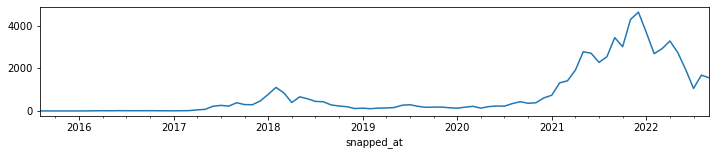

In [81]:
results = seasonal_decompose(df2['price'])
results.observed.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

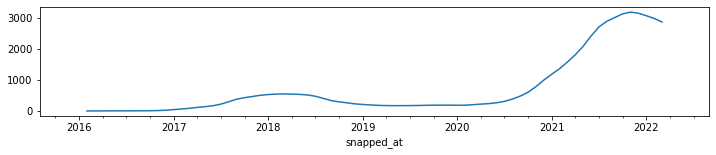

In [82]:
results.trend.plot(figsize=(12,2))

<AxesSubplot:xlabel='snapped_at'>

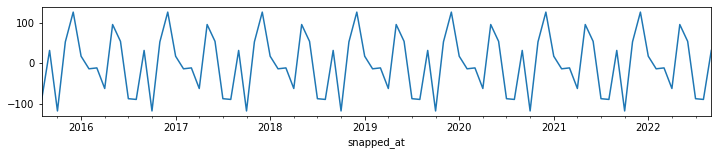

In [83]:
results.seasonal.plot(figsize=(12,2))

In [84]:
len(df2)

86

In [85]:
train = df2.iloc[:-6]
test = df2.iloc[-6:]

In [86]:
from sklearn.preprocessing import MinMaxScaler

In [87]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [88]:
# we do this just on the training data as in real life we have no idea of the actual datra to fit for the test set
scaler.fit(train) # finds the max value in the training set

MinMaxScaler()

In [89]:
# transform the training and test data via the scaler object above. MinMaxscaler doesnt simply divide 
# by athe max or min value... it uses more complex method
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [90]:
# now everything is scaled we need to createa timeseries generator to feed the neural network
from keras.preprocessing.sequence import TimeseriesGenerator

In [91]:
# define generator
# n_input means I will take the first 2 values and predict the third and so on
# the generatr creates this structure based on the inputs and the scaled train data
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [92]:
len(scaled_train)

80

In [93]:
len(generator) # n_input = 2

78

In [94]:
# What does the first batch look like?
X,y = generator[0]
y

array([[0.]])

In [95]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00046281 0.00014342]
Predict this y: 
 [[0.]]


In [159]:
# Redefine to get 12 months back and then predict the next month out
n_input = 48
n_features = 1 # for time series it is 1 as we have one output the prediction (one column of data)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [160]:
# What does the first batch look like?
X,y = generator[0]

In [161]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[4.62814088e-04 1.43423640e-04 0.00000000e+00 8.03914402e-05
 4.08054411e-05 5.61856487e-05 3.31304246e-04 1.48267875e-03
 2.36178394e-03 1.75709155e-03 2.84100249e-03 2.51137604e-03
 2.21777807e-03 2.44089766e-03 2.71415707e-03 2.17977248e-03
 1.67239957e-03 1.59151946e-03 2.16010264e-03 3.55493276e-03
 1.07280630e-02 1.64264898e-02 4.76966076e-02 5.64641186e-02
 4.88294812e-02 8.31796796e-02 6.44868363e-02 6.29027854e-02
 1.01193608e-01 1.67239352e-01 2.38427190e-01 1.82398600e-01
 8.52186001e-02 1.42792212e-01 1.23163854e-01 9.67864652e-02
 9.31026167e-02 6.07228005e-02 5.00590503e-02 4.26951316e-02
 2.43111467e-02 2.82054833e-02 2.27869398e-02 2.90751080e-02
 3.03898475e-02 3.45219661e-02 5.76822884e-02 6.30124251e-02]
Predict this y: 
 [[0.04700319]]


In [162]:
# Create the model , train it and test it
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [163]:
# define model
model = Sequential()
# 100 is the number of neurons. we play around to find a good number and you play around
model.add(LSTM(300, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [164]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 300)               362400    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [165]:
# 1 epoch is a single run through all our data
model.fit(generator,epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 36ms/step - loss: 0.1064
Epoch 2/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0412
Epoch 3/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0337
Epoch 4/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0278
Epoch 5/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0217
Epoch 6/100
32/32 [==============================] - 1s 31ms/step - loss: 0.0239
Epoch 7/100
32/32 [==============================] - 1s 27ms/step - loss: 0.0192
Epoch 8/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0092
Epoch 9/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0184
Epoch 10/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0132
Epoch 11/100
32/32 [==============================] - 1s 34ms/step - loss: 0.0131
Epoch 12/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0145
Epoch 13/100
32/32 [=====

In [166]:
model.history.history.keys()

dict_keys(['loss'])

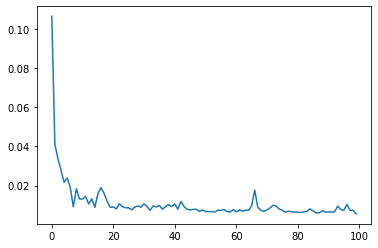

In [167]:
import matplotlib.pyplot as plt
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [172]:
# our model takes the last 12 history steps and predicts the next one 
first_eval_batch = scaled_train[-48:]

In [173]:
first_eval_batch

array([[0.0852186 ],
       [0.14279221],
       [0.12316385],
       [0.09678647],
       [0.09310262],
       [0.0607228 ],
       [0.05005905],
       [0.04269513],
       [0.02431115],
       [0.02820548],
       [0.02278694],
       [0.02907511],
       [0.03038985],
       [0.03452197],
       [0.05768229],
       [0.06301243],
       [0.04700319],
       [0.03696528],
       [0.03862263],
       [0.03926936],
       [0.03257891],
       [0.02771538],
       [0.03850874],
       [0.04694609],
       [0.02858891],
       [0.044187  ],
       [0.04996191],
       [0.0485086 ],
       [0.07447913],
       [0.09382362],
       [0.07741144],
       [0.08307217],
       [0.13190692],
       [0.15915914],
       [0.28391672],
       [0.30540178],
       [0.41306443],
       [0.59873964],
       [0.58401414],
       [0.49146984],
       [0.54804787],
       [0.7419226 ],
       [0.64981109],
       [0.92557189],
       [1.        ],
       [0.79494614],
       [0.57987108],
       [0.629

In [174]:
# reshape the first eval batch
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [175]:
first_eval_batch

array([[[0.0852186 ],
        [0.14279221],
        [0.12316385],
        [0.09678647],
        [0.09310262],
        [0.0607228 ],
        [0.05005905],
        [0.04269513],
        [0.02431115],
        [0.02820548],
        [0.02278694],
        [0.02907511],
        [0.03038985],
        [0.03452197],
        [0.05768229],
        [0.06301243],
        [0.04700319],
        [0.03696528],
        [0.03862263],
        [0.03926936],
        [0.03257891],
        [0.02771538],
        [0.03850874],
        [0.04694609],
        [0.02858891],
        [0.044187  ],
        [0.04996191],
        [0.0485086 ],
        [0.07447913],
        [0.09382362],
        [0.07741144],
        [0.08307217],
        [0.13190692],
        [0.15915914],
        [0.28391672],
        [0.30540178],
        [0.41306443],
        [0.59873964],
        [0.58401414],
        [0.49146984],
        [0.54804787],
        [0.7419226 ],
        [0.64981109],
        [0.92557189],
        [1.        ],
        [0

In [176]:
# to predict basis this first 12 values
model.predict(first_eval_batch)

1/1 [==============================] - 0s 186ms/step


array([[0.5872402]], dtype=float32)

In [177]:
# in order to actually forecast into the future
test_predictions = [] # holding the predictions as we go along

# Last n_input points from the training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
# we use the predicted points to predict further and further into the future 
# so RNN cannot work very well far into the future
# in order to predict into the future we can change the range for example len(test)+6 to forecast another 6 months
# or we can use the actual df2 to train and freely forecast into the future!
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 36ms/step


In [178]:
# Inverse Transformations and Compare
true_predictions = scaler.inverse_transform(test_predictions)

In [179]:
true_predictions

array([[2723.38739003],
       [2409.59451434],
       [2069.37178001],
       [1688.08476995],
       [1276.19414022],
       [ 840.66412736]])

In [180]:
test['Predictions'] = true_predictions

In [181]:
test

,price,Predictions
snapped_at,,
2022-04-01 00:00:00+00:00,3283.302843,2723.387390
2022-05-01 00:00:00+00:00,2738.174136,2409.594514
2022-06-01 00:00:00+00:00,1944.078767,2069.371780
2022-07-01 00:00:00+00:00,1057.630999,1688.084770
2022-08-01 00:00:00+00:00,1682.011374,1276.194140
2022-09-01 00:00:00+00:00,1552.562966,840.664127


<AxesSubplot:xlabel='snapped_at'>

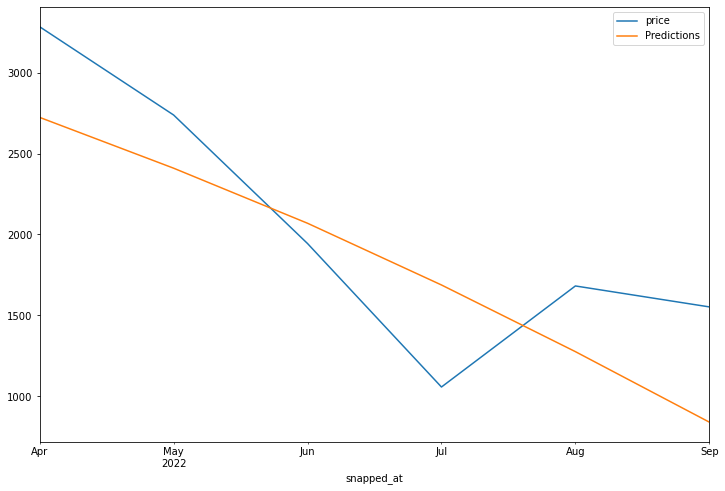

In [182]:
test.plot(figsize=(12,8))

In [183]:
# in order not to retrain every time we can save the model
model.save('my_rnn_model.h5')

In [184]:
# and in order to reload 
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 300)               362400    
                                                                 
 dense_3 (Dense)             (None, 1)                 301       
                                                                 
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________
